# Postprocessing

Testing postprocessing to see whether it would improve the predictions. The two postprocessing techniques used in this notebook are dilation and erosion. We use methods from the scikit-image project

"Morphological dilation sets the value of a pixel to the maximum over all pixel values within a local neighborhood centered about it. [...] Dilation enlarges bright regions and shrinks dark regions." (https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.dilation) 
In our case dilation expands the prediction of "road" class to the pixels that are adjacent to "road" predictions. This is done to test the hypothesis, that the holes and uneven edges of the road predictions could be fixed by expanding the area of the "road" predictions.

"Morphological erosion sets a pixel at (i,j) to the minimum over all pixels in the neighborhood centered at (i,j). Erosion shrinks bright regions and enlarges dark regions." (https://scikit-image.org/docs/stable/api/skimage.morphology.html#skimage.morphology.erosion) 
Erosion reduces the border regions of our "road" class predictions. This is done to test the hypothesis, that the uneven edges of road predictions might yield a worse f1 score and could be fixed by reducing the area of the "road" predictions.


The testing showed that neither method of postprocessing would yield a significant improvement in f1 scores and on the contrary, multiple iterations of dilation or erosion resulted in a worse f1 score. This disproved our hypothesis about the possibility of improving f1 scores by increasing or reducing the area of road predictions. As the postprocessing test were unsuccessful and we were severely constrained by the maximum allowed length of the report, we chose not to include these results in the report but still leave them in the repository for documentation of process.

## Google Colab

The following two cells will be necessary in Google Colab. To avoid problems with imports, they are included in the notebook.

In [1]:
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # noinspection PyUnresolvedReferences
    from google.colab import drive
    drive.mount('/content/drive')

In [2]:
import os
import glob

# let's keep this cell at the beginning for every notebook
# for more convenient training in Google Colab
def get_root_path(filename: str) -> str: 
    """Get root path based on notebook's name."""
    filepath = glob.glob(os.getcwd() + '/**/' + filename, recursive = True)[0]
    return os.path.dirname(os.path.dirname(filepath))

ROOT_PATH = get_root_path('hyperopt.ipynb')
sys.path.append(ROOT_PATH)

# go to the drive directory
os.chdir(ROOT_PATH) if IN_COLAB else None

## Imports

In [3]:
import os
import cv2
import torch
import albumentations as A
import numpy as np
import itertools
import segmentation_models_pytorch as smp

from scripts.preprocessing import RoadDataset, split_data
from scripts.training import train_model, setup_seed
from torch.utils.data import DataLoader
from scripts.evaluation import get_prediction, get_patched_f1
from skimage import morphology

## Data

In [4]:
# specify train directory
train_directory = os.path.join(ROOT_PATH, 'data', 'raw', 'train')

image_path_train, image_path_test, mask_path_train, mask_path_test = split_data(train_directory, 0.1)
# get train and val dataset instances
train_dataset = RoadDataset(image_path_train, mask_path_train)
test_dataset = RoadDataset(image_path_test, mask_path_test)

## Hyperparameters

Since our aim is to see, how different postprocessing influence the training, we fix the model, epochs and batch sizes.

In [5]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'

SEED = 16
BATCH_SIZE = 4
N_CPU = os.cpu_count()
N_EPOCHS = 100

LOADER_PARAMS = {
    'batch_size': BATCH_SIZE,
    'num_workers': N_CPU,
    'persistent_workers': True
}

# Albumentations use many separate image augmentation libraries with different sources for randomization. 
# This is the best effort to have reproducible results. 
setup_seed(SEED)

## Transformations

Define transformations we'll use in evaluating the performance of the model.

In [6]:
# Transforms that will always be applied
base_tf = [A.Resize(height=608, width=608, always_apply=True)]

# Optional transforms that we want to test
transforms_dict = {
    "flip": A.Flip(p=0.5),
    "rotate": A.Rotate(p=0.5, limit=180, border_mode=cv2.BORDER_CONSTANT, rotate_method="ellipse"),
    "brightness": A.RandomBrightnessContrast(p=0.5),
    "shadow": A.RandomShadow(p=0.5,num_shadows_lower=1, num_shadows_upper=4),
    "coarse dropout": A.CoarseDropout(
        max_holes=8, max_height=50, max_width=50, min_holes=None, min_height=25, min_width=25,
    )
}

# Train a model

We train a model to test the postprocessing methods. The chosen model for those test was DeepLabV3Plus with resnet34 encoder, computationally efficient to train on it.

In [8]:

# get the picked tfs as list
tf_selection = base_tf + list(transforms_dict.values())
train_tf = A.Compose(base_tf + tf_selection)
valid_tf = A.Compose(base_tf)


# Create training and validation loaders by providing current K-Fold train/validation indices to Sampler
train_loader = DataLoader(train_dataset.set_tf(train_tf), **LOADER_PARAMS)
valid_loader = DataLoader(test_dataset.set_tf(valid_tf), **LOADER_PARAMS)

# Initialize model
model_ = smp.create_model("DeepLabV3Plus", encoder_name=ENCODER, encoder_weights=ENCODER_WEIGHTS)
criterion_ = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
optimizer_ = torch.optim.Adam(model_.parameters(), lr=0.0005)
scheduler_ = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_,
    T_max=(len(train_loader.dataset) * N_EPOCHS) // train_loader.batch_size,
)

# Train model
train_losses, valid_losses, train_f1s, valid_f1s = train_model(
    model_, (train_loader, valid_loader), criterion_, optimizer_, scheduler_, N_EPOCHS
)


Epoch:   1. Train.      Loss: 0.538 | f1: 0.486: 100%|██████████| 23/23 [00:07<00:00,  3.26it/s]
Epoch:   1. Validation. Loss: 0.640 | f1: 0.369: 100%|██████████| 3/3 [00:00<00:00,  3.75it/s]
Epoch:   2. Train.      Loss: 0.388 | f1: 0.627: 100%|██████████| 23/23 [00:05<00:00,  4.52it/s]
Epoch:   2. Validation. Loss: 0.460 | f1: 0.520: 100%|██████████| 3/3 [00:00<00:00, 17.08it/s]
Epoch:   3. Train.      Loss: 0.319 | f1: 0.691: 100%|██████████| 23/23 [00:05<00:00,  4.35it/s]
Epoch:   3. Validation. Loss: 0.296 | f1: 0.645: 100%|██████████| 3/3 [00:00<00:00, 16.97it/s]
Epoch:   4. Train.      Loss: 0.290 | f1: 0.709: 100%|██████████| 23/23 [00:05<00:00,  4.15it/s]
Epoch:   4. Validation. Loss: 0.354 | f1: 0.572: 100%|██████████| 3/3 [00:00<00:00, 16.58it/s]
Epoch:   5. Train.      Loss: 0.259 | f1: 0.730: 100%|██████████| 23/23 [00:06<00:00,  3.76it/s]
Epoch:   5. Validation. Loss: 0.240 | f1: 0.653: 100%|██████████| 3/3 [00:00<00:00, 12.16it/s]
Epoch:   6. Train.      Loss: 0.230 | f1

# Visualize dilation effects

Visualizations of the dilation effects. The changes are too small to observe on the pixel-level predictions but changes can be observed on the 16x16 patches. 

f1: 0.82
Dilated f1: 0.82


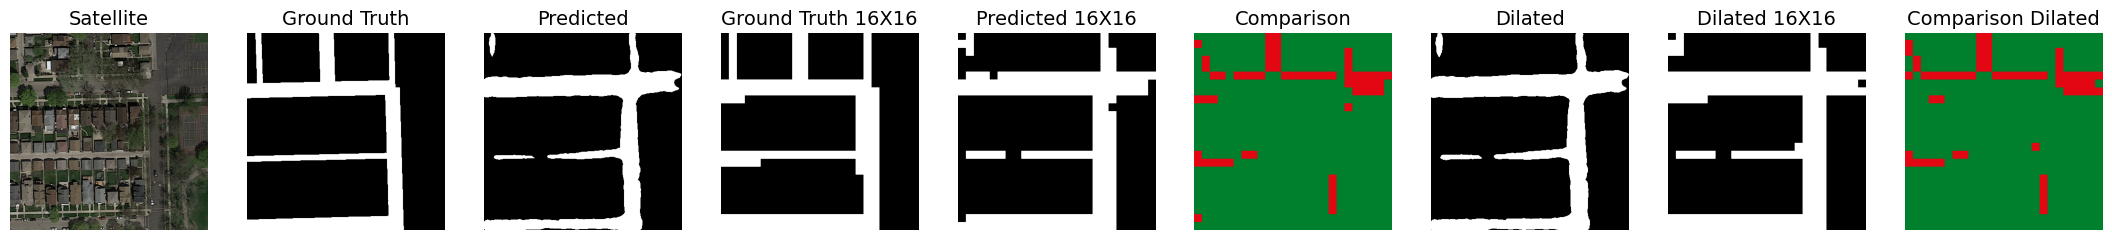

f1: 0.66
Dilated f1: 0.66


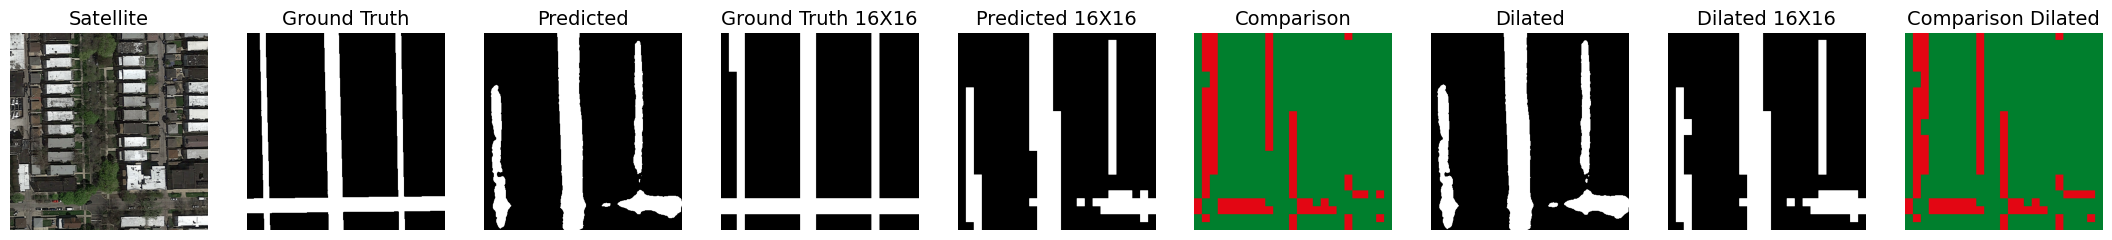

f1: 0.87
Dilated f1: 0.87


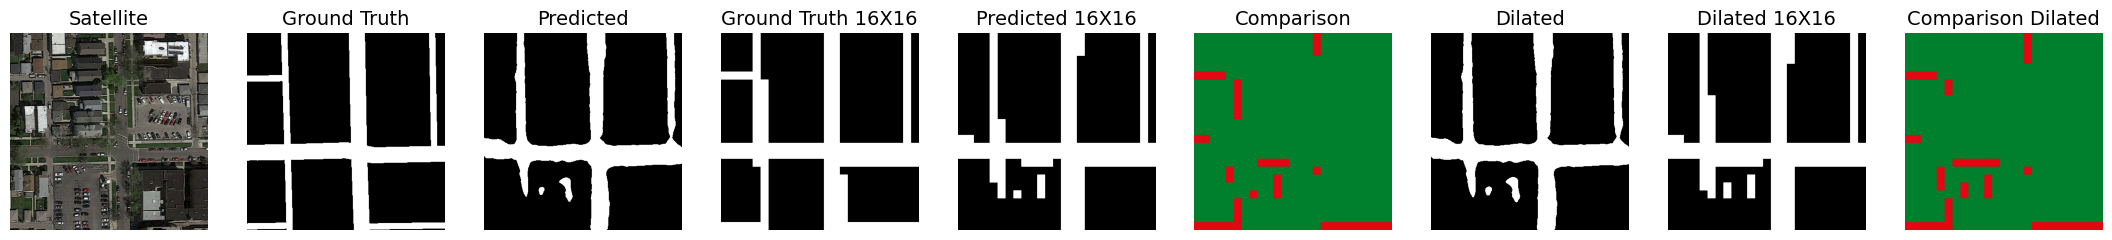

f1: 0.79
Dilated f1: 0.78


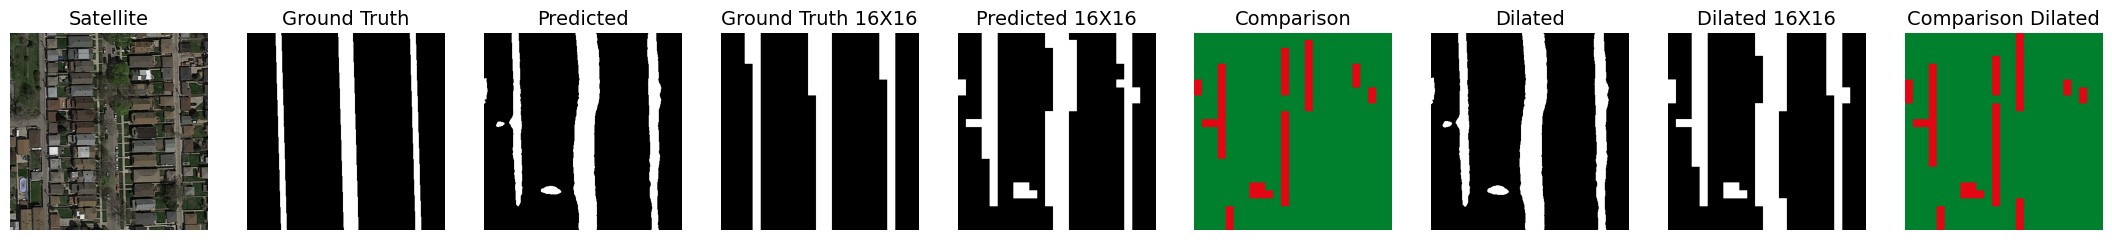

f1: 0.87
Dilated f1: 0.85


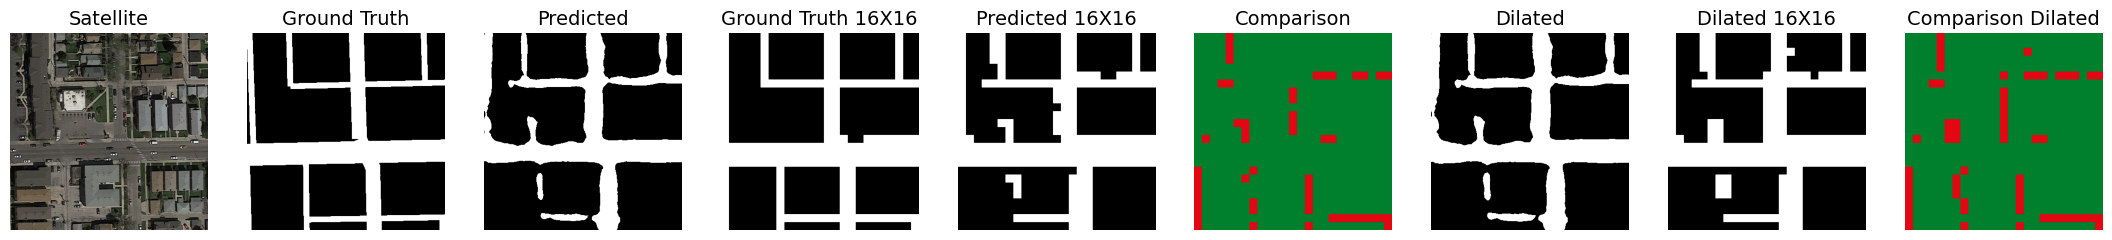

In [9]:
from scripts.plotting import plot_n_predictions

test_loader = DataLoader(test_dataset, batch_size=1)
plot_n_predictions(model_, test_loader, num_images=5)

# Test multiple iterations of dilation

We test how multiple iterations of dilation affect the f1 score. 

In [14]:
from collections import defaultdict

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dictionary to hold f1 scores
dilation_results = defaultdict(lambda: np.array([]))

# Iterate over test dataset
for image, label in test_loader:
    image, label = image.to(device), label.to(device)
    
    # Get prediction on test image with no dilation
    predicted = get_prediction(model_, image)
    dilation_results[0] = np.append(dilation_results[0], get_patched_f1(predicted, label))
    
    dilated = predicted.copy()
    
    # Apply dilation on test image 5 times and save f1 score after each dilation
    for i in range(1,6):
        dilated = morphology.binary_dilation(dilated).astype(np.uint8)
        dilation_results[i] = np.append(dilation_results[i], get_patched_f1(dilated, label))

# Print results
for key, results in dilation_results.items():
    print(f'Dialation count={key}, f1: {results.mean():.4f}')

Dialation count=0, f1: 0.6558
Dialation count=1, f1: 0.6518
Dialation count=2, f1: 0.6461
Dialation count=3, f1: 0.6368
Dialation count=4, f1: 0.6227
Dialation count=5, f1: 0.6090


In [15]:
# Dictionary to hold f1 scores
erosion_results = defaultdict(lambda: np.array([]))

# Iterate over test dataset
for image, label in test_loader:
    image, label = image.to(device), label.to(device)

    # Get prediction on test image with no erosion
    predicted = get_prediction(model_, image) 
    erosion_results[0] = np.append(erosion_results[0], get_patched_f1(predicted, label))
    
    eroded = predicted.copy()
    
    # Apply dilation on test image 5 times and save f1 score after each erosion
    for i in range(1,6):
        eroded = morphology.binary_erosion(eroded).astype(np.uint8)
        erosion_results[i] = np.append(erosion_results[i], get_patched_f1(eroded, label))
    
# Print results
for key, results in erosion_results.items():
    print(f'Erosion count={key}, f1: {results.mean():.4f}')

Erosion count=0, f1: 0.6558
Erosion count=1, f1: 0.6587
Erosion count=2, f1: 0.6544
Erosion count=3, f1: 0.6409
Erosion count=4, f1: 0.6305
Erosion count=5, f1: 0.6133


# Summary

The testing setup we used, showed no significant improvement from dilation and erosion.

Further research could be done by testing erosion and dilation on a larger set of models or by using different postprocessing methods such as changing a pixels value to the most common value of its neighbours.